In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method), PGD (Projected Gradient Descent) and UAP (Universal adversarial perturbations). To enhance your understanding, you will implement the PGD and UAP attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- UAP Attack from scratch
- Visualization
- Adversarial Training


Name: Alireza Farajtabrizi  

Student Number: 403206554

In [1]:
import torch
import torchattacks
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)

In [3]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
model = resnet(len(classes))
model = model.to(device)
################################ End #########################################

In [6]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [7]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")
################################ End #########################################

Epoch [1/100], Loss: 1.535958
Epoch [2/100], Loss: 1.136340
Epoch [3/100], Loss: 0.931761
Epoch [4/100], Loss: 0.773815
Epoch [5/100], Loss: 0.662042
Epoch [6/100], Loss: 0.552037
Epoch [7/100], Loss: 0.451464
Epoch [8/100], Loss: 0.377972
Epoch [9/100], Loss: 0.307832
Epoch [10/100], Loss: 0.248097
Epoch [11/100], Loss: 0.211959
Epoch [12/100], Loss: 0.176073
Epoch [13/100], Loss: 0.136948
Epoch [14/100], Loss: 0.126280
Epoch [15/100], Loss: 0.106697
Epoch [16/100], Loss: 0.093143
Epoch [17/100], Loss: 0.072704
Epoch [18/100], Loss: 0.065872
Epoch [19/100], Loss: 0.070996
Epoch [20/100], Loss: 0.051236
Epoch [21/100], Loss: 0.037583
Epoch [22/100], Loss: 0.044097
Epoch [23/100], Loss: 0.038511
Epoch [24/100], Loss: 0.040651
Epoch [25/100], Loss: 0.035510
Epoch [26/100], Loss: 0.038019
Epoch [27/100], Loss: 0.032422
Epoch [28/100], Loss: 0.027919
Epoch [29/100], Loss: 0.026087
Epoch [30/100], Loss: 0.022533
Epoch [31/100], Loss: 0.024085
Epoch [32/100], Loss: 0.021466
Epoch [33/100], L

In [8]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')
################################ End #########################################

Test Accuracy: 74.88%


In [9]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [10]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
def attack_model_eval(attack, model, dataloader):
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        adv_images = attack(images, labels)

        outputs = model(adv_images)
        _, predicted = outputs.max(1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy
############################################################################################
model.load_state_dict(torch.load("resnet18_cifar10_model_pretrained.pth",  weights_only=True))

epsilon = 1/255
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)

accuracy = attack_model_eval(fgsm_attack, model, testloader)
print(f'\nAccuracy after FGSM attack with epsilon = {epsilon:.4f}: {accuracy:.2f}%')
################################ End #########################################

100%|██████████| 79/79 [00:04<00:00, 18.19it/s]


Accuracy after FGSM attack with epsilon = 0.0039: 53.64%


In [11]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################
epsilon = 4/255
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)

accuracy = attack_model_eval(fgsm_attack, model, testloader)
print(f'\nAccuracy after FGSM attack with epsilon = {epsilon:.4f}: {accuracy:.2f}%')
################################ End #########################################

100%|██████████| 79/79 [00:03<00:00, 23.85it/s]


Accuracy after FGSM attack with epsilon = 0.0157: 22.33%


In [12]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################
epsilon = 8/255
fgsm_attack = torchattacks.FGSM(model, eps=epsilon)

correct = 0
total = 0

accuracy = attack_model_eval(fgsm_attack, model, testloader)
print(f'\nAccuracy after FGSM attack with epsilon = {epsilon:.4f}: {accuracy:.2f}%')
################################ End #########################################

100%|██████████| 79/79 [00:03<00:00, 23.30it/s]


Accuracy after FGSM attack with epsilon = 0.0314: 10.70%


## PGD Attack from scratch (15 pts)

In this section you should implement PGD attack from scratch.

In [7]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model.eval()
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, images, labels):

        images = images.to(device)
        labels = labels.to(device)

        out = self.model(images)
        _, preds = torch.max(out, 1)

        perturbed_images = images.clone()
        perturbed_images.to(device)
        perturbed_images = perturbed_images + (torch.rand_like(perturbed_images) * 2 - 1) * self.epsilon
        perturbed_images = torch.clamp(perturbed_images, 0, 1)


        ##############################################################################
        # Implement a k step PGD attack of size alpha                                #
        # while always staying within epsilon distance from the initial point        #
        # Use cross entropy loss                                                     #
        ##############################################################################
        for _ in range(self.steps):
            # Separate the tensor from the previous computation graph and enable a new computation graph for it
            perturbed_images = perturbed_images.detach()
            perturbed_images.requires_grad = True

            outputs = self.model(perturbed_images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            grad = torch.autograd.grad(loss, perturbed_images, retain_graph=False, create_graph=False)[0]

            perturbed_images = perturbed_images + self.alpha * grad.sign()
            perturbed_images = torch.clamp(perturbed_images, min=images - self.epsilon, max=images + self.epsilon)
            perturbed_images = torch.clamp(perturbed_images, 0, 1)

        # to avoid changing the images that were miss-classified already
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                perturbed_images[i] = images[i]
            ################################ End #########################################

        return perturbed_images

In [14]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################
for k in k_list:
    pgd_attack = LinfPGDAttack(model=model, k=k)
    accuracy = attack_model_eval(pgd_attack, model, testloader)
    print(f'Accuracy after PGD attack with k-step = {k}: {accuracy:.2f}%')

################################ End #########################################

100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


Accuracy after PGD attack with k-step = 2: 17.78%


100%|██████████| 79/79 [00:11<00:00,  6.68it/s]


Accuracy after PGD attack with k-step = 4: 4.89%


100%|██████████| 79/79 [00:21<00:00,  3.60it/s]

Accuracy after PGD attack with k-step = 8: 0.80%


## UAP Attack from scratch (15 pts)

In this section you should implement UAP attack from scratch.

In [8]:
class UAPAttack(object):

    def __init__(self, model, epsilon=8/255, delta=2/255, max_iters=10, data_loader=None, attack=None, compare_to_grand_truth=False):
        self.model = model
        self.epsilon = epsilon
        self.delta = delta
        self.max_iters = max_iters
        self.data_loader = data_loader
        self.attack = attack # whether to use attacks like deepfool fgsm pgd ... or just use the gradient descent
        self.compare_to_grand_truth = compare_to_grand_truth # what target labels use to compare? (in article they use model output not the grand_truth to compare)

        # Initialize universal perturbation to zero
        self.uap = 0

    def generate_uap(self):
        """
        Generate Universal Adversarial Perturbation (UAP) using the dataset.
        """
        for _ in tqdm(range(self.max_iters)):
            for images, labels in self.data_loader:
                images, labels = images.to(device), labels.to(device)

                # Add the current universal perturbation to the images
                perturbed_images = images.clone().detach()
                perturbed_images.requires_grad = True
                perturbed_images = torch.clamp(perturbed_images + self.uap, 0, 1)

                # Perform forward pass with perturbed images
                outputs = self.model(perturbed_images)
                _, preds = torch.max(outputs, 1)

                if self.compare_to_grand_truth:
                    misclassified_index = preds==labels
                else :
                    outputs_imgs = self.model(images)
                    _, preds_imgs = torch.max(outputs_imgs, 1)
                    misclassified_index = preds==preds_imgs
                ##############################################################################
                # Implement misclassification logic                                          #
                # Find misclassified images and calculate the gradient                       #
                # Update the universal perturbation using the calculated gradient            #
                ##############################################################################
                if self.attack is None:
                    loss = nn.CrossEntropyLoss()(outputs[misclassified_index], preds_imgs[misclassified_index])
                    grad = torch.autograd.grad(loss, perturbed_images, retain_graph=False, create_graph=False)[0]
                    v = grad.sign()[misclassified_index]
                    self.uap += self.delta * v.mean(dim=0)
                else:
                    v = self.attack(perturbed_images[misclassified_index], labels[misclassified_index]) - perturbed_images[misclassified_index]
                    self.uap += v.mean(dim=0)
                ################################ End #########################################

                # Project the universal perturbation to the epsilon ball
                ##############################################################################
                # Implement projection logic to keep UAP within epsilon bounds               #
                ##############################################################################
                self.uap = torch.sign(self.uap) * torch.minimum(torch.abs(self.uap), torch.tensor(self.epsilon))
                torch.cuda.empty_cache()
                ################################ End #########################################

        return self.uap

    def __call__(self, image):
        """
        Apply the universal perturbation to a given image.
        """
        image = image.to(device)
        perturbed_image = torch.clamp(image + self.uap, 0, 1)
        return perturbed_image

In [9]:
##############################################################################
# Evaluate UAP attack on the trained model with max_iters = 10               #
##############################################################################
model.load_state_dict(torch.load("resnet18_cifar10_model_pretrained.pth", weights_only=True))
model.eval()
max_iters = 10
##############################################################################
uap_attack = UAPAttack(model=model, epsilon=10/255, delta=4/255, max_iters=max_iters, data_loader=trainloader, attack=None)
uap = uap_attack.generate_uap()

correct_clean = 0
correct_adv = 0
fooled_adv = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        # predict for orginal image
        images, labels = images.to(device), labels.to(device)
        outputs_img = model(images)
        _, predicted_img = torch.max(outputs_img, 1)

        # predict for perturbed image
        perturbed_images = uap_attack(images)
        outputs_pert = model(perturbed_images)
        _, predicted_pert = torch.max(outputs_pert, 1)

        correct_clean += (predicted_img == labels).sum().item()
        correct_adv += (predicted_pert == labels).sum().item()
        fooled_adv += (predicted_pert == predicted_img).sum().item()
        total += labels.size(0)

accuracy_clean = correct_clean / total * 100
accuracy_adv = correct_adv / total * 100
fooling_ratio = (1-fooled_adv/ total) * 100
print(f'\nAccuracy on clean data: {accuracy_clean:.2f}%')
print(f'Accuracy on perturbed data (UAP applied): {accuracy_adv:.2f}%')
print(f'Fooling Ratio on perturbed data (UAP applied): {fooling_ratio:.2f}%')
################################ End #########################################

100%|██████████| 79/79 [00:10<00:00,  7.75it/s]


Accuracy on clean data: 74.88%
Accuracy on perturbed data (UAP applied): 54.41%
Fooling Ratio on perturbed data (UAP applied): 39.05%


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model

In [10]:
##############################################################################
# Implement the function described                                           #
##############################################################################
def adv_vs_org_plot(original_image, perturbed_image, original_label, perturbed_label):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image\nPredicted Label: {original_label}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_image)
    plt.title(f'Perturbed Image\nPredicted Label: {perturbed_label}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
################################ End #########################################

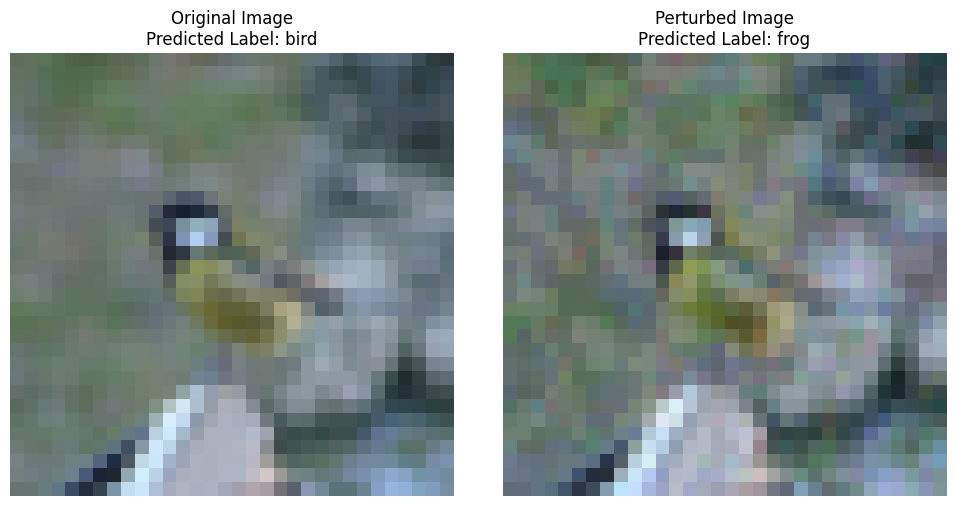

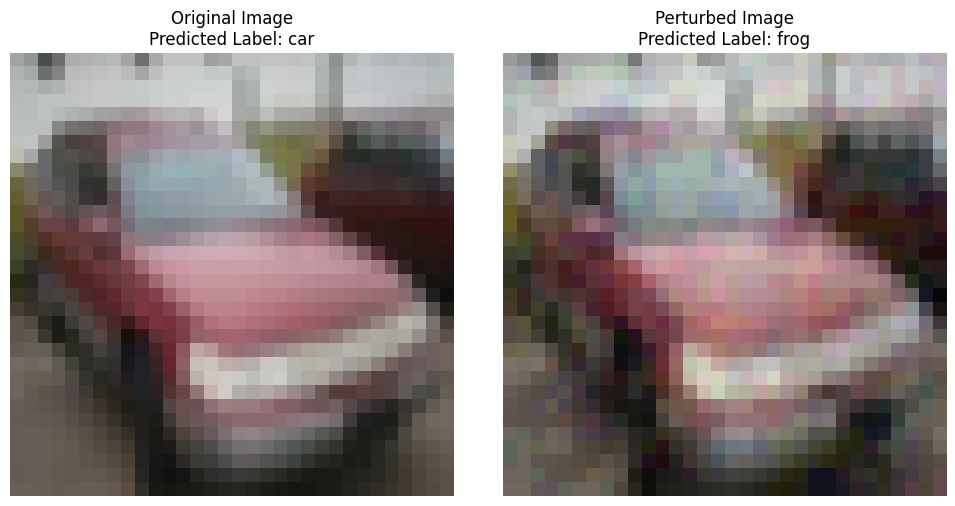

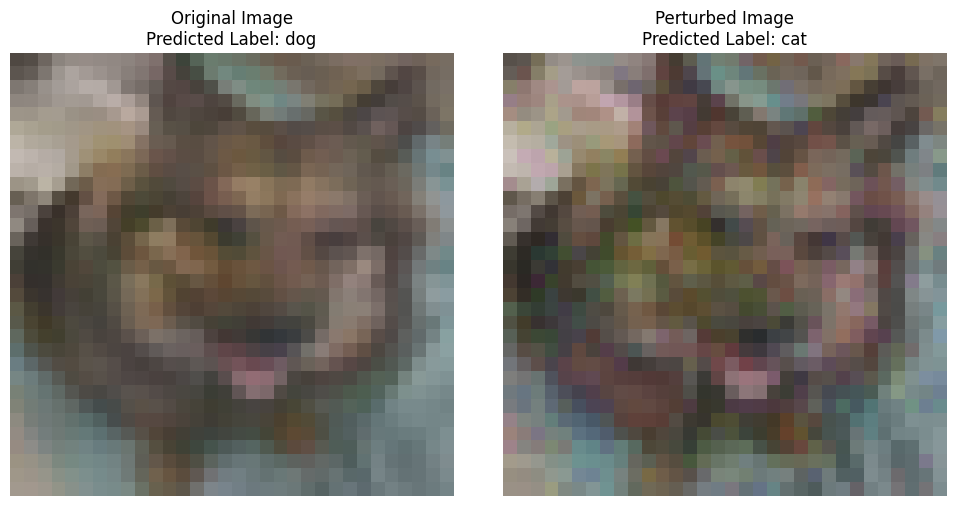

In [11]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################
np.random.seed(42)
random_indices = np.random.choice(len(testset), 3, replace=False)
attack = torchattacks.FGSM(model, eps=8/255)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for index in random_indices:
    img, label = testset[index]
    pert_img = attack(img.unsqueeze(0), torch.tensor(label).unsqueeze(0))
    org_img = img.permute(1,2,0).cpu().numpy()
    pert_label = model(pert_img).argmax(1).item()
    pert_img = pert_img[0].permute(1,2,0).cpu().numpy()
    adv_vs_org_plot(org_img, pert_img, classes[label], classes[pert_label])
################################ End #########################################

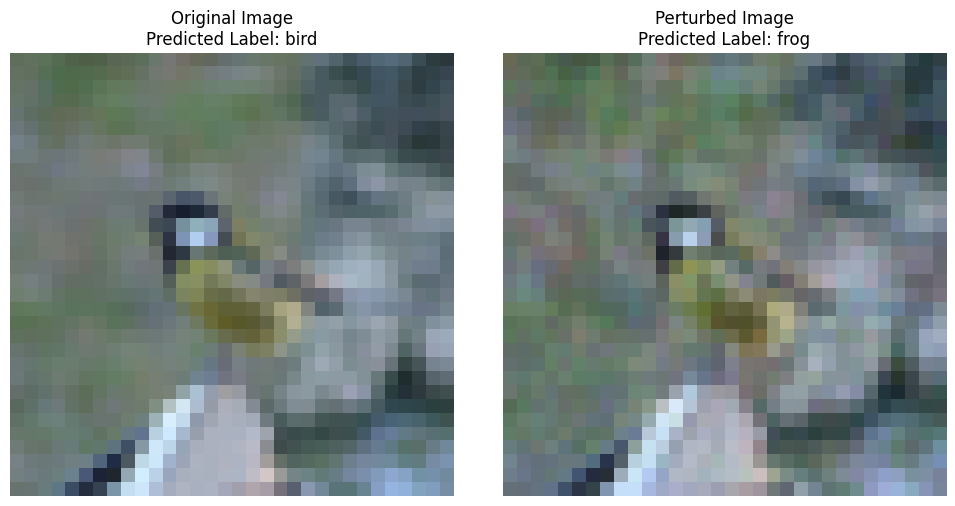

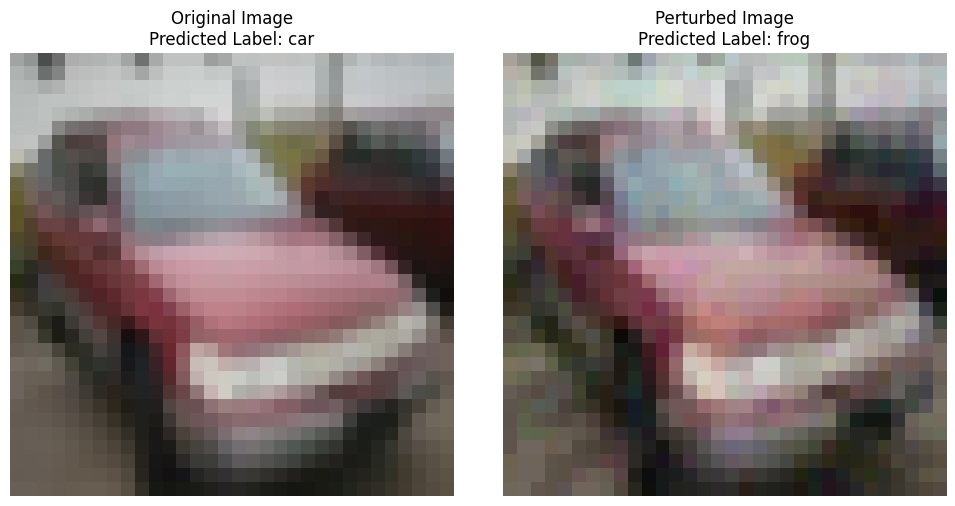

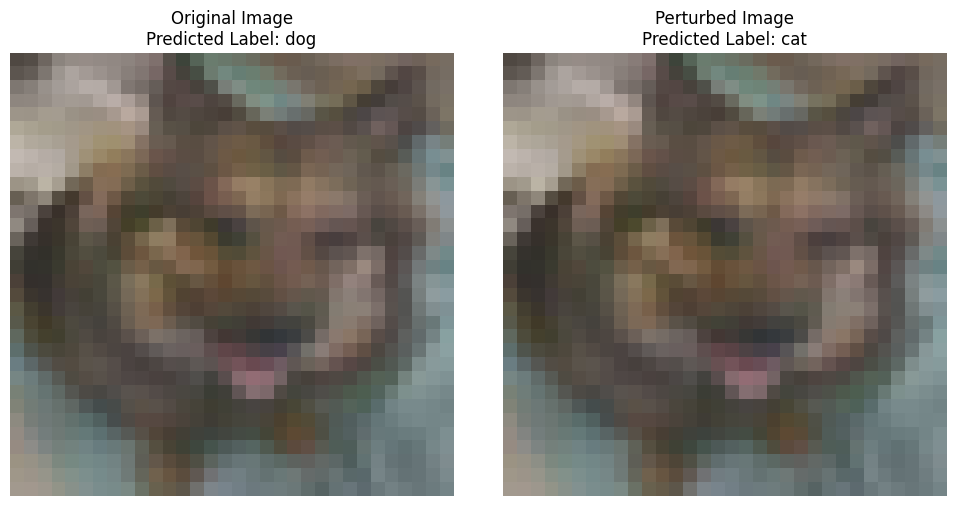

In [12]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################
np.random.seed(42)
random_indices = np.random.choice(len(testset), 3, replace=False)
attack = LinfPGDAttack(model, k=8, epsilon=8/255)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for index in random_indices:
    img, label = testset[index]
    pert_img = attack(img.unsqueeze(0), torch.tensor(label).unsqueeze(0))
    org_img = img.permute(1,2,0).cpu().numpy()
    pert_label = model(pert_img).argmax(1).item()
    pert_img = pert_img[0].permute(1,2,0).detach().cpu().numpy()
    adv_vs_org_plot(org_img, pert_img, classes[label], classes[pert_label])
################################ End #########################################

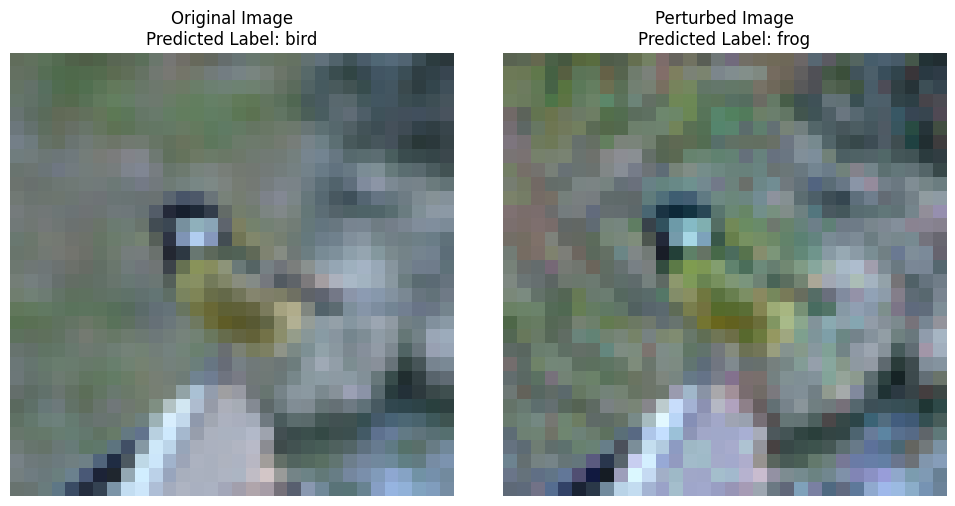

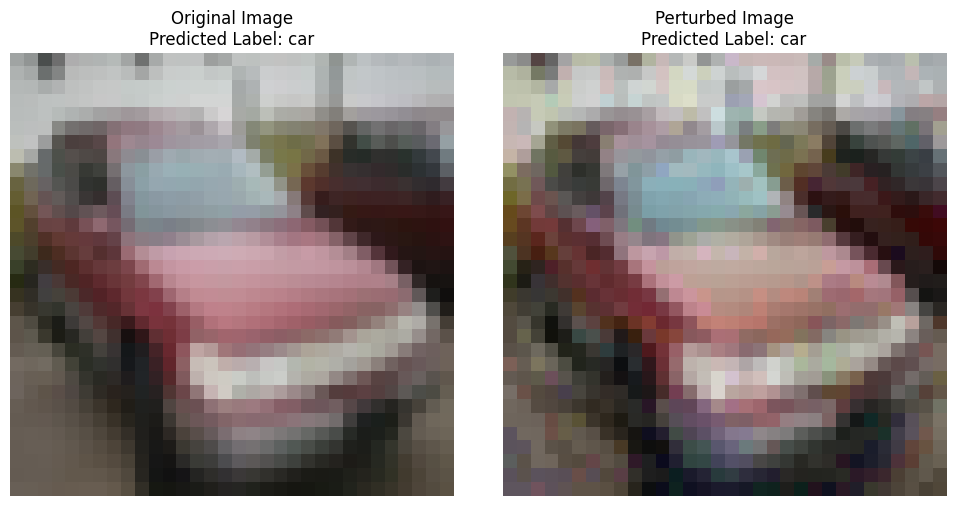

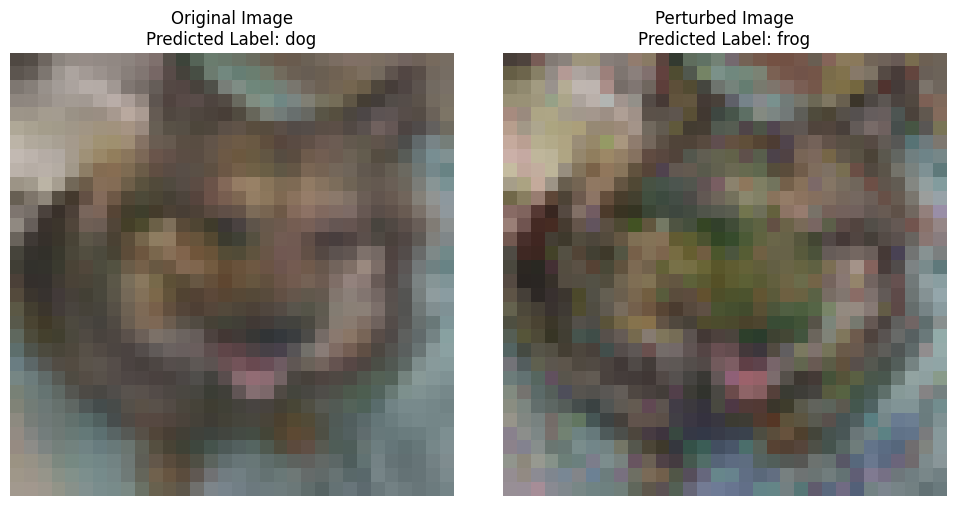

In [13]:
##############################################################################
# Choose 3 random images from testset and run UAP attack and visualize       #
##############################################################################
np.random.seed(42)
random_indices = np.random.choice(len(testset), 3, replace=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for index in random_indices:
    img, label = testset[index]
    pert_img = uap_attack(img.unsqueeze(0))
    org_img = img.permute(1,2,0).cpu().numpy()
    pert_label = model(pert_img).argmax(1).item()
    pert_img = pert_img[0].permute(1,2,0).detach().cpu().numpy()
    adv_vs_org_plot(org_img, pert_img, classes[label], classes[pert_label])

################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [23]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = resnet(len(classes))
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100
epsilon = 8/255

# Your code goes here
for epoch in range(epochs):
    running_loss = 0.0

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True

        clean_outputs = adv_model(inputs)
        clean_loss = 0.5 * criterion(clean_outputs, labels)
        clean_loss.backward()

        adv_images = inputs + epsilon * inputs.grad.detach().sign()
        adv_outputs = adv_model(adv_images)
        adv_loss = 0.5 * criterion(adv_outputs, labels)

        adv_loss.backward()
        optimizer.step()
        running_loss += (adv_loss + clean_loss).item()

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")
################################ End #########################################

Epoch [1/100], Loss: 1.987096
Epoch [2/100], Loss: 1.749823
Epoch [3/100], Loss: 1.662124
Epoch [4/100], Loss: 1.582921
Epoch [5/100], Loss: 1.517421
Epoch [6/100], Loss: 1.448668
Epoch [7/100], Loss: 1.386623
Epoch [8/100], Loss: 1.320826
Epoch [9/100], Loss: 1.257890
Epoch [10/100], Loss: 1.202438
Epoch [11/100], Loss: 1.137851
Epoch [12/100], Loss: 1.066052
Epoch [13/100], Loss: 1.007270
Epoch [14/100], Loss: 0.954924
Epoch [15/100], Loss: 0.850646
Epoch [16/100], Loss: 0.811050
Epoch [17/100], Loss: 0.702555
Epoch [18/100], Loss: 0.618411
Epoch [19/100], Loss: 0.572716
Epoch [20/100], Loss: 0.504499
Epoch [21/100], Loss: 0.434225
Epoch [22/100], Loss: 0.381162
Epoch [23/100], Loss: 0.345190
Epoch [24/100], Loss: 0.300754
Epoch [25/100], Loss: 0.282174
Epoch [26/100], Loss: 0.241477
Epoch [27/100], Loss: 0.220119
Epoch [28/100], Loss: 0.201019
Epoch [29/100], Loss: 0.183959
Epoch [30/100], Loss: 0.183931
Epoch [31/100], Loss: 0.167327
Epoch [32/100], Loss: 0.155467
Epoch [33/100], L

In [24]:
adv_model.eval()
model_name = "adv_resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(adv_model.state_dict(), model_PATH)

In [25]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################
adv_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = adv_model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

################################ End #########################################

Test Accuracy: 64.99%


In [26]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################
epsilon = 8/255
fgsm_attack = torchattacks.FGSM(adv_model, eps=epsilon)

accuracy = attack_model_eval(fgsm_attack, adv_model, testloader)
print(f'\nAccuracy after FGSM attack with epsilon = {epsilon:.4f}: {accuracy:.2f}%')
################################ End #########################################

100%|██████████| 79/79 [00:03<00:00, 22.23it/s]


Accuracy after FGSM attack with epsilon = 0.0314: 23.48%


In [28]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################
pgd_attack = LinfPGDAttack(model=adv_model, k=4)

accuracy = attack_model_eval(pgd_attack, adv_model, testloader)
print(f'\nAccuracy after PGD attack with k-step = {4}: {accuracy:.2f}%')
################################ End #########################################

100%|██████████| 79/79 [00:11<00:00,  6.63it/s]


Accuracy after PGD attack with k-step = 4: 23.95%


In [29]:
##############################################################################
#  Run UAP attack on the adversarially trained model with max_iters = 10     #
##############################################################################
max_iters = 10
uap_attack = UAPAttack(model=adv_model, epsilon=10/255, delta=4/255, max_iters=max_iters, data_loader=trainloader, attack=None)
uap = uap_attack.generate_uap()

correct_clean = 0
correct_adv = 0
fooled_adv = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(testloader):
        # predict for orginal image
        images, labels = images.to(device), labels.to(device)
        outputs_img = adv_model(images)
        _, predicted_img = torch.max(outputs_img, 1)

        # predict for perturbed image
        perturbed_images = uap_attack(images)
        outputs_pert = adv_model(perturbed_images)
        _, predicted_pert = torch.max(outputs_pert, 1)

        correct_clean += (predicted_img == labels).sum().item()
        correct_adv += (predicted_pert == labels).sum().item()
        fooled_adv += (predicted_pert == predicted_img).sum().item()
        total += labels.size(0)

accuracy_clean = correct_clean / total * 100
accuracy_adv = correct_adv / total * 100
fooling_ratio = (1-fooled_adv/ total) * 100
print(f'\nAccuracy on clean data: {accuracy_clean:.2f}%')
print(f'Accuracy on perturbed data (UAP applied): {accuracy_adv:.2f}%')
print(f'Fooling Ratio on perturbed data (UAP applied): {fooling_ratio:.2f}%')
################################ End #########################################

100%|██████████| 79/79 [00:02<00:00, 38.65it/s]


Accuracy on clean data: 64.99%
Accuracy on perturbed data (UAP applied): 62.56%
Fooling Ratio on perturbed data (UAP applied): 16.68%


Answer the following questions:
- What happened to the accuracy of the adversarially trained model? its decreased compared to normal training
- What do you conclude from the result of the FGSM attack on the adversarially trained model? the accuracy increased on test adversarial examples that were generated with FGSM and its because we made the model more robust by adversarial training 
- What do you conclude from the result of the PGD attack on the adversarially trained model? the accuracy increased on test adversarial examples that were generated with PGD even that the adversarial training data was with FGSM method. The reason is that both FGSM and PGD take advantage of same weakness of DNN models
- What do you conclude from the result of the UAP attack on the adversarially trained model? my answer is the same for the UAP with what I said about PGD
- What is you final conclusion? Adversarial Training is a trade-off between robustness and clean-accuracy you lose one a little and you get of another. The procedure makes the model learn better decesion bounderies and it ends up with some samples missclassified. 